# Conversión de imagenes en escala de grises a color usando TensorFlow

Carlos Iván Fonseca Mondragón - A01771689

In [15]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, MaxPool2D, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential, Model
from sklearn.model_selection import train_test_split

In [16]:
print("Dispositivos físicos disponibles:", tf.config.list_physical_devices())

Dispositivos físicos disponibles: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [17]:
# Cargar conjuntos de imágenes (no es necesario aplicar transformaciones)
COLOR_PATH = 'color_processed/'
GRAY_PATH = 'gray_processed/'

def load_image_pair():
    gray_images = []
    color_images = []
    # Use the current working directory which was changed by %cd
    gray_dir = os.path.join(os.getcwd(), GRAY_PATH)
    color_dir = os.path.join(os.getcwd(), COLOR_PATH)

    for img in os.listdir(gray_dir): #Mismo número de imágenes en ambas carpetas
        image_gray = tf.io.read_file(os.path.join(gray_dir, img)) #Cargar cada imagen
        image_color = tf.io.read_file(os.path.join(color_dir, img))

        gray_img_tensor_int = tf.image.decode_jpeg(image_gray, channels=1)
        color_img_tensor_int = tf.image.decode_jpeg(image_color, channels=3)

        gray_img_float = tf.image.convert_image_dtype(gray_img_tensor_int, tf.float32, )
        color_img_float = tf.image.convert_image_dtype(color_img_tensor_int, tf.float32)

        gray_images.append(gray_img_float)
        color_images.append(color_img_float)

    return gray_images, color_images

In [18]:
X, y = load_image_pair()
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Luego separar train de validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=42)

In [19]:
IMAGE_SIZE = (64, 64) 
BATCH_SIZE = 128
EPOCHS = 135
LATENT_DIM = 128

In [20]:
# Creación del Modelo Autoencoder
encoder = Sequential([
    Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 1)),

    Conv2D(32, (3,3), strides=1, padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(0.3),

    Conv2D(64, (3,3), strides=2, padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    

    Conv2D(128, (3,3), strides=2, padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Conv2D(256, (3,3), strides=2, padding='same', activation='relu'),
    BatchNormalization(),
    Dropout(0.4),

    Flatten(),
    Dense(LATENT_DIM, activation='relu'),  # latent_dim
    
    Dropout(0.5)
])

In [21]:
decoder = Sequential([
    Input(shape=((LATENT_DIM,))),
    Dense(8*8*256, activation='relu'),
    Reshape((8, 8, 256)),
    
    Conv2DTranspose(256, (3,3), strides=1, padding='same', activation='relu'),
    BatchNormalization(),

    Conv2DTranspose(128, (3,3), strides=2, padding='same', activation='relu'),
    BatchNormalization(),

    Conv2DTranspose(64, (3,3), strides=2, padding='same', activation='relu'), 
    BatchNormalization(),

    Conv2DTranspose(32, (3,3), strides=2, padding='same', activation='relu'),
    BatchNormalization(),

    Conv2D(3, (3,3), padding='same', activation='sigmoid')  # salida [0,1]
])

In [22]:
model = Sequential([encoder, decoder])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4))
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128)            │     2,487,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 64, 64, 3)      │     3,093,699 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,580,739 (21.29 MB)

 Trainable params: 5,578,819 (21.28 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [25]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_autoencoder_model.keras', save_best_only=True, monitor='val_loss'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, min_delta=1e-4)    
]

In [26]:
history = model.fit(np.array(X_train), np.array(y_train),
          validation_data=(np.array(X_test), np.array(y_test)),
          epochs=EPOCHS,
          batch_size=BATCH_SIZE,
          callbacks=callbacks
            )

Epoch 1/135
36/36 ━━━━━━━━━━━━━━━━━━━━ 32s 796ms/step - loss: 0.2010 - val_loss: 0.2171 - learning_rate: 0.0010
Epoch 2/135
36/36 ━━━━━━━━━━━━━━━━━━━━ 28s 766ms/step - loss: 0.1564 - val_loss: 0.2216 - learning_rate: 0.0010
Epoch 3/135
36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 721ms/step - loss: 0.1498 - val_loss: 0.2238 - learning_rate: 0.0010
Epoch 4/135
36/36 ━━━━━━━━━━━━━━━━━━━━ 26s 735ms/step - loss: 0.1474 - val_loss: 0.2230 - learning_rate: 0.0010
Epoch 5/135
36/36 ━━━━━━━━━━━━━━━━━━━━ 29s 807ms/step - loss: 0.1454 - val_loss: 0.2195 - learning_rate: 0.0010
Epoch 6/135
36/36 ━━━━━━━━━━━━━━━━━━━━ 30s 840ms/step - loss: 0.1438 - val_loss: 0.2147 - learning_rate: 0.0010
Epoch 7/135
36/36 ━━━━━━━━━━━━━━━━━━━━ 31s 867ms/step - loss: 0.1422 - val_loss: 0.2179 - learning_rate: 0.0010
Epoch 8/135
36/36 ━━━━━━━━━━━━━━━━━━━━ 27s 746ms/step - loss: 0.1412 - val_loss: 0.2063 - learning_rate: 0.0010
Epoch 9/135
36/36 ━━━━━━━━━━━━━━━━━━━━ 27s 754ms/step - loss: 0.1402 - val_loss: 0.1988 - learning_rate:

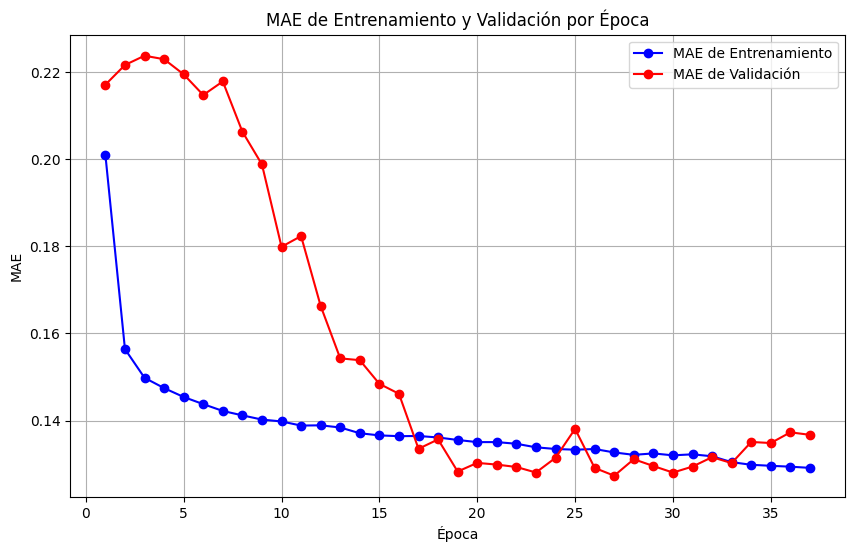

In [30]:
import matplotlib.pyplot as plt

# Obtener los valores de MAE de entrenamiento y validación del historial
train_mae = history.history['loss']
val_mae = history.history['val_loss']
epochs = range(1, len(train_mae) + 1)

# Graficar perdidas
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_mae, 'bo-', label='MAE de Entrenamiento')
plt.plot(epochs, val_mae, 'ro-', label='MAE de Validación')
plt.title('MAE de Entrenamiento y Validación por Época')
plt.xlabel('Época')
plt.ylabel('MAE')
plt.legend()
plt.grid(True)